# Modules and dependencies

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mpc
from scipy.interpolate import interp1d
from astropy import units, constants
import sympy as sp
import pickle

import pygro

from pulsars.delay_observer import DelayObserver
from pulsars.orbit import GROrbit, KeplerOrbit
from pulsars.utils.pi_formatter import pi_formatter

# Constants

Set the values of the physical constants from the `astropy` module

In [2]:
M = 4e+6*units.Msun
c = constants.c.to('au/s')             
G_N = constants.G.to('au3/(Msun s2)')

r_G = G_N*M/c**2

# Metric and geodesics

Definition of the `Metric` object from `pygro`. We will focus on the Schwarzschild black hole metric for now.

In [3]:
name = "Schwarzschild Black Hole"

coordinates = ["t", "r", "theta", "phi"]

transform_functions = [
    "t",
    "r*sin(theta)*cos(phi)",
    "r*sin(theta)*sin(phi)",
    "r*cos(theta)"
]

line_element = "-(1-2*G*M/(c**2*r))*c**2*dt**2+dr**2/(1-2*G*M/(c**2*r))+r**2*(dtheta**2+sin(theta)**2*dphi**2)"

metric_SCH = pygro.Metric(
    name = name,
    coordinates = coordinates,
    line_element = line_element,
    transform = transform_functions,
    M = 1,
    G = 1,
    c = 1,
)

Calculating inverse metric...
Calculating symbolic equations of motion:
- 1/4
- 2/4
- 3/4
- 4/4
Adding to class a method to get initial u_0...
The metric_engine has been initialized.


The `Metric` object has to be passed to the `GeodesicEngine`, which is the object that pereforms the actual numerical integration of the geodesic equation, whereas the `Metric` object only deals with the symbolic calculations of the geodesic equations starting from the expression of the line element.

In [4]:
geo_engine_SCH = pygro.GeodesicEngine(metric_SCH, integrator = 'dp45', backend = "lambdify")
geo_engine_SCH.set_stopping_criterion("2*G*M/(c**2*r) - 1 < -0.01", "horizon")

Linking Schwarzschild Black Hole to the Geodesic Engine
Metric linking complete.


Let's now consider a massive test particle in orbit around the black hole. I will use the `GROrbit` wrapper of the `Geodesic` class within `pygro` which has built-in functions to set initial conditions starting from the Keplerian orbital elements of the orbit.

The `GROrbit` class has as methods:
- `set_orbital_paramaters`: which allow to fix a number of Keplerian elements and compute automatically the missing ones (if no inclination angle is specified it is assumed the the orbit lies on the equatorial plane);

- `get_orbital_paramaters`: returns an array with the complete set of orbital parameters;

- `integrate`: which is a wrapper around the `GeodesicEngine.integrate()` method of `pygro`. It accepts as first and second arguments the intial and final time of integration and as `**kwargs` all the `GeodesicEngine.integrate()`, such as the integration precision and accuracy and the maximum timestep `hmax` in case it is needed to fix it.

In this case we fix the semi-major axis of the orbit and the eccentricity and let the `GROrbit` compute the orbital period. We then retrieve `T` as the first element of the `get_orbital_paramaters` array and use its value to integrate from half period (this ensures that the orbit starts at apocenter) up to 5 periods.

In [5]:
a = 150 # Astronomical units (it depends on the units that we have given to G and c)
e = 0.7

Toy = GROrbit(geo_engine_SCH)
Toy.set_orbital_parameters(a = a, e = e, t_P = 0)

T = Toy.get_orbital_params(Toy.params)[0]
Toy.integrate(0.5*T, 5*T, PrecisionGoal=14, AccuracyGoal = 14)

Longitude of ascending node not specified, set to 0.
Argument of the pericenter not specified, set to 0.
Inclination not specified, set to 0.


Let's visualize the resulting geodesic. We use the `Metric.transform()` method to convert from the Schwarzschild coordinates to pseudo-cartesian coordinates and then plot the orbit on the $x-y$ plane

Text(0, 0.5, 'y [AU]')

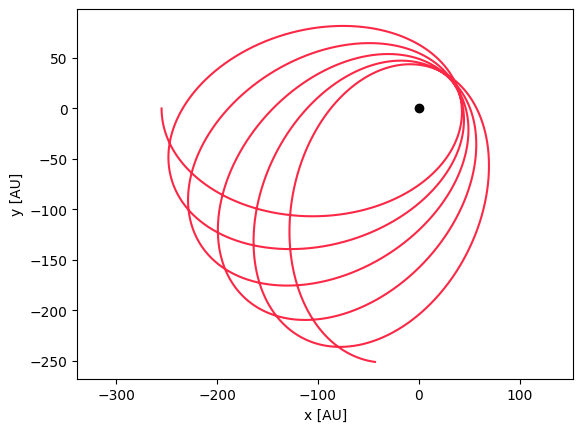

In [29]:
t, x, y, z = metric_SCH.transform(Toy.geo.x.transpose())

fig, ax = plt.subplots()

ax.plot(x, y, color = '#fc2846')

ax.plot(0, 0, 'ok')

ax.axis('equal')

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')

# Delay Observer

The new portion of code written for the pulsar timing problem is all contained in the `DelayObserver` class. The constructor of this class accepts as arguments the three spatial coordinates that define the position of the observer around the black hole (the coordinates are supposed to be the same adopted in the `Metric` object). Upon initializing the class, the code will automatically derive the symbolic quantities that are required to integrate the photon propagation time (i.e. all the quantities from Eq. 18 to Eq. 34 in the paper). We will consider a very distant observer ($10^7$ astronomical units) to demonstrate that the code is capable of handling this situation.

In [7]:
r_obs = 1e+9

observer_Sch = DelayObserver(r_obs, np.pi/2, 0, geo_engine_SCH)

For example, the integrand functions for the angular and temporal integrals can be accessed with the `DelayObesrver.T_integrand_symb` and `DelayObesrver.Phi_integrand_symb` attributes

In [8]:
observer_Sch.T_integrand_symb

-c*r/(sqrt((2.0*G*M*b**2 - b**2*c**2*r + r**3)/r**3)*(2*G*M - c**2*r)) - 1

# Photon propagation time

Let's now fix a position on the pulsar's orbit and compute the photon travel time for that specific case. The `GROrbit` class has several built-in methods to specifiy a position on the orbit. One can obtain the position at a give proper time $\tau$ with the `get_orbit_position_tau(tau)` method, or the position at a given coordinate time $t$ with the `get_orbit_position(t)` method, or, finally, the position at a specific orbital phase (in this case we refer to the relativisic orbital phase in Eq. 60 of the paper) with the metod `get_orbit_position_phase(phi)`.

We will use the latter to identify positions on the orbit. Let's consider, for example a point on the orbit corresponding to an orbital phase $\varphi= 5\pi/4$ (remember that we have started integration at `0.5T`, so the first orbital half $\varphi\in[0,\pi]$ is not included in the integration).

All these methods return the position of the object in pseudo-cartesian coordinates. If we want the Schwazschild coordinates at the time of the emission we can use the `get_orbit_coordinates_phase(phi)` method, which behave exactly `get_orbit_position_phase(phi)` but does not pass the results through the `Metric.transform()` method.

Text(0, 0.5, 'y [AU]')

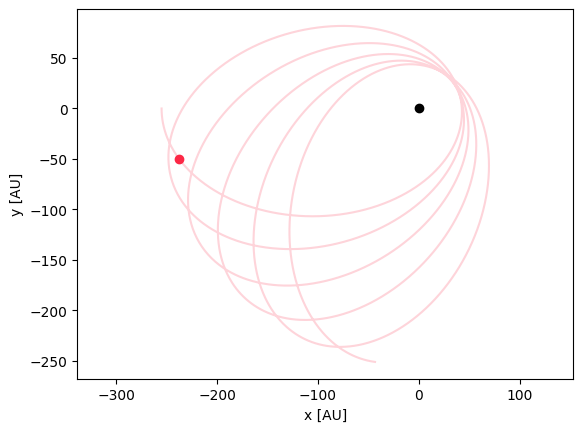

In [28]:
phi = 5*np.pi/4

E = Toy.get_orbit_position_phase(phi)
t_E, r_E, theta_E, phi_E = Toy.get_orbit_coordinates_phase(phi)

# Let's plot the position to see point of emission of the photon

t, x, y, z = metric_SCH.transform(Toy.geo.x.transpose())
fig, ax = plt.subplots()
ax.plot(x, y, color = '#fc2846', alpha = 0.2)
ax.plot(E[0], E[1], 'o', color = '#fc2846')
ax.plot(0, 0, 'ok')
ax.axis('equal')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')

We can now consider the photon emitted by the pulsar at the emission position E and that reaches the observer at the position where we have placed it. The `DelayObserver` class has built-in methods to solve both the emitter-observer problem and to integrate the photon propagation time numerically, strating from the underlying symbolic expression.

The first method that we will use is the `get_b()` method. This funcion takes as arguments the radial and angular coordinates of the emission of the photon on the Emitter-Observer-BlackHole plane and gives as outputs the corresponding impact parameter and a `bool` value that is `True` if the photon propagation is direct and `False` if it is indirect (see section 3 in the paper).

Since the method is based on the `scipy.integrate.quad` method, additional keywords arguments `tol` and `limit` fix the relative integration toleranche and the maximum number of division for the Quadature integration algorithm.

In [20]:
phi_EO = observer_Sch.get_phi(E)

b, direct = observer_Sch.get_b(r_E, phi_EO, epsrel = 1e-16, limit = 150)

print(f"The impact parameter for the geodesic connecting emitter and observer is {b:.2f} AU and the propagation is {'direct' if direct else 'indirect'}.")

The impact parameter for the geodesic connecting emitter and observer is 65.27 AU and the propagation is indirect.


Let's visualize such geodesic. The `DelayObserver` class has a built-in method to convert the impact parameter into initial conditions that we can later integrate to get the photon geodesic trajectory \
.....

In [21]:
def get_photon_initial_conditions(self, t_E, r_E, theta_E, phi_E):

    E = self.metric.transform([t_E, r_E, theta_E, phi_E])[1:]

    phi_EO = self.get_phi(E)

    b, direct = self.get_b(r_E, phi_EO, tol = 1e-14, limit = 100)

    Lagr = self.metric.Lagrangian()

    Es = Lagr.diff(self.metric.u[0])
    Ls = Lagr.diff(self.metric.u[3])

    ut = sp.lambdify(self.metric.x, sp.solve(self.metric.evaluate_parameters(self.metric.subs_functions(Es-1)), self.metric.u[0])[0])(t_E, r_E, theta_E, phi_E)
    uphi = sp.lambdify(self.metric.x, sp.solve(self.metric.evaluate_parameters(self.metric.subs_functions(Ls-b)), self.metric.u[3])[0])(t_E, r_E, theta_E, phi_E)

    sign = 1 if direct else -1

    ur = sign*sp.lambdify((*self.metric.x, self.metric.u[0], self.metric.u[3]), self.metric.evaluate_parameters(self.metric.subs_functions(sp.sqrt((-self.metric.g[0,0]*self.metric.u[0]**2-self.metric.g[3,3]*self.metric.u[3]**2)/self.metric.g[1,1]))))(t_E, r_E, theta_E, phi_E, ut, uphi)

    return [ut, ur, 0.0, uphi]

In [22]:
photon = pygro.Geodesic('null', geo_engine_SCH, verbose = True)

photon.initial_x = Toy.get_orbit_coordinates_phase(phi)
photon.initial_u = get_photon_initial_conditions(observer_Sch, *Toy.get_orbit_coordinates_phase(phi))

geo_engine_SCH.integrate(photon, 1e+10, 1, AccuracyGoal = 14, PrecisionGoal = 14)

/Users/riccardodellamonica/Projects/Pulsar-Timing/env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'y [AU]')

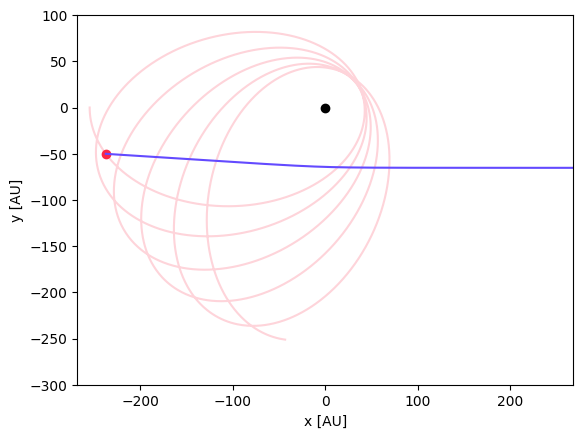

In [26]:
# Let's plot the position to see point of emission of the photon

t, x, y, z = metric_SCH.transform(Toy.geo.x.transpose())
t_p, x_p, y_p, z_p = metric_SCH.transform(photon.x.transpose())

fig, ax = plt.subplots()

ax.plot(x, y, color = '#fc2846', alpha = 0.2)

ax.plot(E[0], E[1], 'o', color = '#fc2846')
ax.plot(0, 0, 'ok')

ax.plot(x_p, y_p, color = '#634aff')


ax.axis('equal')

ax.set_xlim(-200, 200)
ax.set_ylim(-300, 100)

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')


Text(0, 0.5, 'y [AU]')

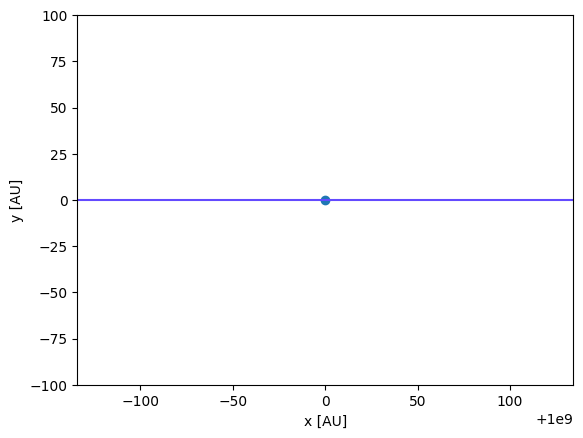

In [27]:
# Let's plot the position of the observer to make sure the the photon reaches the observer

t_p, x_p, y_p, z_p = metric_SCH.transform(photon.x.transpose())

fig, ax = plt.subplots()

ax.plot(r_obs, 0, 'o')

ax.plot(x_p, y_p, color = '#634aff')

ax.axis('equal')

ax.set_xlim(r_obs-100, r_obs+100)
ax.set_ylim(-100, 100)

ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')

Finally, we cane compute the travel time for the photon. To do this we can apply the `DelayObserver.get_travel_time()` method which solves the emitter-observer problem (through the `get_b` method) and integrates the photon travel time on the corresponding photon. This methods accepts as argument the point of emission $E$ and keywords arguments to set both the emitter-observer and the temporal integral precision tolerances.

In [15]:
Delta_t = observer_Sch.get_travel_time(E, epsrel_t=1e-11, limit_t = 100)

print(f"The photon propagation time is {Delta_t:.9} s")

The photon propagation time is 1.00000029e+09 s


# Photon propagation time profile

We can now apply the same methodology on several points along the orbit, to see the phase-dependence of the photon propagation time. Let's consider orbital phases in the range $\phi\in[\pi, 6\pi]$ and derive the corresponding photon propagation time for 250 points along the orbit

In [18]:
phi_arr = np.linspace(np.pi, 6*np.pi, 250)

Delta_t_arr = [observer_Sch.get_travel_time(Toy.get_orbit_position_phase(phi), epsrel_t=1e-11, limit_t = 100) for phi in phi_arr]

# Ignore the warnings, they are only alerting of some integration thresrhold being reached in the emitter-observer problem, but they do not alter the results

/Users/riccardodellamonica/Projects/Pulsar-Timing/pulsars/delay_observer.py:107: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return (quad(self.Phi_integrand, r, r_o, args = (np.abs(b), *self.metric.get_parameters_val(), ), epsrel = epsrel, limit = limit, points = [r,1e+7])[0])*np.sign(b)
/Users/riccardodellamonica/Projects/Pulsar-Timing/pulsars/delay_observer.py:112: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return (quad(self.Phi_integrand, r, r_o, args = (np.abs(b), *self.metric.get_parameters_val(), ), epsrel = epsrel, limit = limit, points = [

Let's visualize the result making use of the built-in `pi_formatter` utility class that allow to express the tick label as fractions of $\pi$

Text(0, 0.5, 'Photon propagation time [sec]')

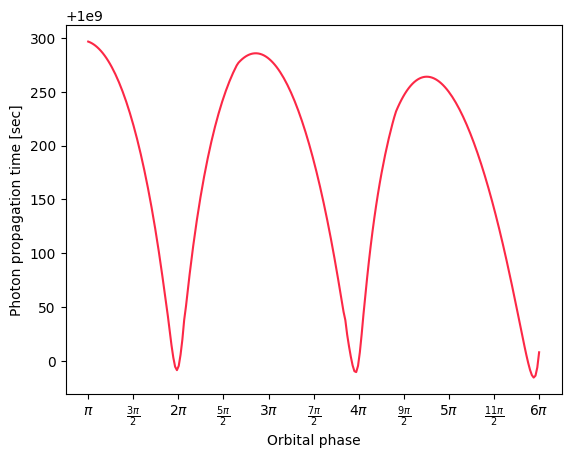

In [17]:
fig, ax = plt.subplots()

ax.plot(phi_arr, Delta_t_arr, color = '#fc2846')

ax.set_xticks([np.pi/2*k+np.pi for k in range(11)])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(pi_formatter))

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Photon propagation time [sec]')
